### **Loading Dependencies:**

**Mounting Google Drive:**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# for accessing tabular data
import pandas as pd
import numpy as np
import os
os.chdir('/content/drive/My Drive/')
# adding classweight
from sklearn.utils import class_weight
# Evaluation Metric
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# for visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns 
from prettytable import PrettyTable
# backend
import keras
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback
# for transfer learning
from keras.applications import VGG16, VGG19
from keras.applications import DenseNet121
from keras.applications import ResNet50, ResNet152
from keras.applications import InceptionV3
from efficientnet.keras import EfficientNetB0, EfficientNetB3, EfficientNetB4
from keras.applications import Xception
# for model architecture
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Activation, Flatten
# for Tensorboard visualization
from keras.callbacks import TensorBoard 
# for Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
try:
    x_train = np.load("processed_images/training.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_validation = np.load("processed_images/validation.npy",mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_test = np.load("processed_images/test.npy", mmap_mode = None,allow_pickle = False, fix_imports = True)
    print("Loaded Successfully...\n")
    print(x_train.shape)
    print(x_validation.shape)
    print(x_test.shape)
except:
    print("file not exists")

Loaded Successfully...

(3112, 512, 512, 3)
(550, 512, 512, 3)
(1928, 512, 512, 3)


In [ ]:
train_labels = pd.read_csv('training.csv')
train_labels = train_labels['diagnosis']
validation_labels = pd.read_csv('validation.csv')
validation_labels = validation_labels['diagnosis']
print("Training:",train_labels.shape[0])
print("Validation:",validation_labels.shape[0])

Training: 3112
Validation: 550


### **Transforming Target Labels:**

There are five outcomes in our model i.e., [0,1,2,3,4]. Now we can transform these labels either using<br>
1.   **One hot encoding**<br>
For example if the target label is 2 then it will encoded as [0,0,1,0,0].<br>
2.   **Ordinal Regression**<br>
For example if the target label is 2 then it will encoded as [1,1,1,0,0] which means the sample with class-2 also belongs to the classes before it like 0 and 1(here)<br>

According to the this [paper](https://arxiv.org/pdf/0704.1028.pdf) using ordinal regression especially in case of categorical target variables that too in healthcare will be of more helpful.

In [ ]:
def ordinal_encoding(labels): 
    """
    This function is used to create one_hot_encoding of the labels.
    E.x: category = 3 -> one-hot-encoding [1,1,1,1,0].
         category = 2 -> one-hot-encoding [1,1,1,0,0].
    """
    y_train = pd.get_dummies(labels).values
    y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
    y_train_multi[:, 4] = y_train[:, 4]

    for i in range(3, -1, -1):
         y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])
    return y_train_multi
labels_train = ordinal_regression(train_labels)
labels_validation = ordinal_regression(validation_labels)
print(labels_train.shape)
print(labels_validation.shape)
print("Ex: Original Category: {}\n After one_hot_encoding: {}".format(train_labels.iloc[23],labels_train[23]))

(3112, 5)
(550, 5)
Ex: Original Category: 0
 After one_hot_encoding: [1 0 0 0 0]


### **Computing Classweight:**

Since the data set is highly imbalanced adding classweight can make it balanced by adding weights to each of the classes.<br>
The class with more weight means they are less in samples.
Similarly the class with less weight means they are more in samples.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',[0,1,2,3,4],train_labels)
print(class_weights)

[0.40573664 1.98216561 0.73309776 3.79512195 2.47968127]


### **Cohen's Kappa:**

*    It is used to measure the degree of agreement between raters for categorical data.
*    It is an extension to accuracy where it finds the simple percent agreement calculation (True predictions / Total predictions). Kappa score makes it more robust by considering the agreement occured by chance.

<img src='https://imgur.com/fOLz44W.png'/>

where, <br>
Po is observed agreement (same as accuracy).<br>
Pe is chance of disagreement observed between raters.<br>

**Quadratic Weighted Cohen's kappa Score:**

*    The weighted kappa allows disagreements to be weighted differently and it is usefully when codes are ordered.
*    It makes use of three matrices.
    1.    The matrix of observed scores.
    2.    The matrix of expected scores.
    3.    Weight matrix

<img src='https://imgur.com/fWJssqK.png'/>

where,<br>
wij is elements in weight matrix<br>
xij is elements in observed matrix<br>
mij is elements in expected matrix<br>

**Why using weighted kappa metric??**<br>
*    It is usefull when the target labels are ordered.
*    In case of disagreement, the score is given according to the distance of predicted and observed elements. It is not only taking care of agreement but also posing penality on the disagreement.
*    The score will be higher if the true prediction is 3 and model predicted as 2 and will be lower if the model prediction is 4. This property will be very helpful because in medical getting higher than expected will be okay because on later diagnosis it can be rectified. But if the patient got class-1 and it is predicted as class-0 then it will be a problem because that patient is ignored which can adversly effect the patient as well as the reputation of the hospital.

Read more about kappa score [here](https://en.wikipedia.org/wiki/Cohen%27s_kappa#Weighted_kappa) and [here](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps).




In [ ]:
def kappa_metric(y_true, y_pred):
    """
    This function is used for calculating kappa score between the model predicted values and true values
    Args: y_true (np.ndarray or list) - true values
          y_pred (np.ndarray or list) - model predicted value
    Output: _kappa_ (integer or float) - return's kappa score
    """
    y_true = y_true.sum(axis=1) - 1        
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(int).sum(axis=1) - 1
    _kappa_ = cohen_kappa_score( y_true, y_pred,  weights='quadratic' )
    return _kappa_

In [ ]:
class Metrics(Callback):
    def __init__(self, path):
        ''' Initialization of variables '''
        super(Callback, self).__init__()
        self.path = path
    def ModelCheckPoint(self, path):
        ''' This function is used for Storing the model weights if val_kappa improves from all the previous epochs'''
        self.model.save(path)
    def on_train_begin(self, logs={}):
        self.val_kappas = []
    def on_epoch_end(self, epoch, logs={}):
        ''' This function is used for calculating kappa score on each epoch and updates the validation kappa score if it improves from the previous epochs'''
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1
        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )
        self.val_kappas.append(_val_kappa)
        print(f"\b - val_kappa:  {_val_kappa:.4f}")       
        if _val_kappa == max(self.val_kappas):
            print("\n\t\tValidation Kappa has improved. Saving model to {}...".format(self.path))
            self.ModelCheckPoint(self.path)
        else: 
            print("\n\t\tValidation kappa did not improved from {}".format(max(self.val_kappas)))
        return

In [ ]:
class PerformanceMetric:
    def __init__(self,actual_labels,predicted_labels):
        ''' Initialization of variables '''
        self.actual_labels = actual_labels
        self.predicted_labels = predicted_labels
    def single_value_conversion(self):
        ''' This function is used for Converting model predicted values into single values
           Ex: model_predicted_value: [0,1,0,0,0] and it converts as 1'''
        predicted_labels = self.predicted_labels > 0.5
        prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
        prediction_ordinal[:,4] = predicted_labels[:,4]
        for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
        self.predicted_labels = prediction_ordinal.sum(axis = 1)-1
        self.actual_labels = self.actual_labels.sum(axis = 1)-1
    def confusionMatrix(self):
        ''' This function is used for calculating confusion matrix between model predicted values and true values using sklearn implementation.'''
        confusion_matrix_ = confusion_matrix(self.actual_labels, self.predicted_labels)
        return confusion_matrix_
    def precision(self, matrix):
        ''' This function is used for calculating precision matrix between predicted values and true values using confusion matrix'''
        precision_matrix =(((matrix.T)/(matrix.sum(axis=1))).T)
        return precision_matrix
    def recall(self, matrix):
        ''' this function is used for calculating recall matrix between predicted values and true values using confusion matrix'''
        recall_matrix =(matrix/matrix.sum(axis=0))
        return recall_matrix
    def subplot_(self, matrix, i, title):
        ''' This function is used for subplots'''
        plt.subplot(1,3,i)
        labels = [1,2,3,4,5]
        sns.heatmap(matrix, annot=True, cmap=sns.light_palette('green'),linewidths = 0.8,cbar = False, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.xlabel('Predicted Class Labels')
        plt.ylabel('Actual Class Labels')
    def plotting(self):
        """
        This function is used for calculating number of misclassified points, confusion, recall and precision matrixes and plotting it using subplots.
        """
        self.single_value_conversion()
        confusion_matrix = self.confusionMatrix()
        #print("Number of misclassified points: ",(len(self.actual_labels)-np.trace(confusion_matrix))/len(self.actual_labels)*100,"\n")
        precision_matrix = self.precision(confusion_matrix)
        recall_matrix = self.recall(confusion_matrix)
        plt.figure(figsize=(20,5))
        self.subplot_(confusion_matrix, 1, 'Confusion Matrix')
        self.subplot_(precision_matrix, 2, 'Precision')
        self.subplot_(recall_matrix, 3, 'Recall')
        plt.show()

In [ ]:
def plotting(iter, val_kappa):
    """
    This function is used for plotting validation_kappa on each epoch
    Args: iter(integer) - Number of epochs we runned on model training.
          val_kappa(list) - validation kappa score on each epoch
    Output: None - It doesn't return anything.
    """
    epoch = [i for i in range(iter)]
    plt.plot(epoch,val_kappa)
    plt.title('validation_kappa on each epoch')
    plt.xlabel('epoch')
    plt.ylabel('val_kappa')
    plt.grid()
    plt.show()

In [ ]:
def test_prediction(predicted_labels):
    '''
    Making predictions of the probability scores. The class with more score will be taken as predicted class. 
    Arguments:
    predicted_labels - (np.array) - probability score of given sample
    '''
    predicted_labels = predicted_labels > 0.5
    prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
    prediction_ordinal[:,4] = predicted_labels[:,4]
    for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
    predicted_labels = prediction_ordinal.sum(axis = 1)-1
    return predicted_labels 

## **Model-Training:**

### **Baseline Model:**

First we are starting with a basemodel to estimate the final score.
Here we are using 
1.    3 Convolutional layers with fixed kernel size of 2x2 and padding = same with relu activation
2.    3 Maxpooling layers with fixed kernel size of 2x2.
3.    Global average pooling after max pooling.
4.    One dropout layer.
5.    4 Dense layers.

In [ ]:
def baseline_model():
    ''' This function is used for building a base line convolutional neural network architecture '''
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[512,512,3], activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=128, activation = 'relu'))
    model.add(Dense(units=256, activation = 'relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(5, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
baseline = baseline_model()
baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 511, 511, 16)      208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 254, 254, 32)      2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

In [ ]:
baseline = baseline_model()
kappa_metrics = Metrics('/content/drive/My Drive/models/baseline1.h5')
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/baseline1')
call_backs = [kappa_metrics,tensorboard]
history = baseline.fit(x_train, labels_train, epochs = 30, batch_size = 32, verbose = 2, class_weight = class_weight, validation_data = (x_validation, labels_validation), callbacks = call_backs)

Train on 3112 samples, validate on 550 samples
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 3s - loss: 1.0752 - accuracy: 0.7190 - val_loss: 0.4214 - val_accuracy: 0.7829
 - val_kappa:  0.0901

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/baseline1.h5...
Epoch 2/30
 - 2s - loss: 0.5839 - accuracy: 0.7546 - val_loss: 0.4111 - val_accuracy: 0.7749
 - val_kappa:  0.0000

		Validation kappa did not improved from 0.09013247055438767
Epoch 3/30
 - 3s - loss: 0.4887 - accuracy: 0.7662 - val_loss: 0.3937 - val_accuracy: 0.8033
 - val_kappa:  0.1947

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/baseline1.h5...
Epoch 4/30
 - 2s - loss: 0.4312 - accuracy: 0.7883 - val_loss: 0.3862 - val_accuracy: 0.7938
 - val_kappa:  0.1235

		Validation kappa did not improved from 0.19468523950904004
Epoch 5/30
 - 2s - loss: 0.4126 - accuracy: 0.8009 - val_loss: 0.3741 - val_accuracy: 0.8451
 - val_kappa:  0.4352

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/baseline1.h5...
Epoch 6/30
 - 2s

In [ ]:
baseline = baseline_model()
baseline.load_weights("/content/drive/My Drive/models/baseline1.h5")
result1 = baseline.evaluate(x_validation,labels_validation)
y_pred = baseline.predict(x_validation)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result1[0],4),np.round(result1[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

550/550 [==============================] - 6s 12ms/step
After running the model for 30 epochs we got loss = 0.2453 Accuracy = 0.9018 kappa_score = 0.6931 on validation data


In [ ]:
ytrain_baseline = baseline.predict(x_train)
ytrain_baseline = test_prediction(ytrain_baseline)
print("First five data points predictions in training:",ytrain_baseline[:5])
print("length of traindata prediction:",ytrain_baseline.shape,"\n")

yvalidation_baseline = baseline.predict(x_validation)
yvalidation_baseline = test_prediction(yvalidation_baseline)
print("First five data points predictions in validation:",yvalidation_baseline[:5])
print("length of validation data prediction:",yvalidation_baseline.shape,"\n")

ytest_baseline = baseline.predict(x_test)
ytest_baseline = test_prediction(ytest_baseline)
print("First five data points predictions in test:",ytest_baseline[:5])
print("length of test data prediction:",ytest_baseline.shape)

First five data points predictions in training: [0 2 0 2 2]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 2 2 2]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 3 2 2 0]
length of test data prediction: (1928,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


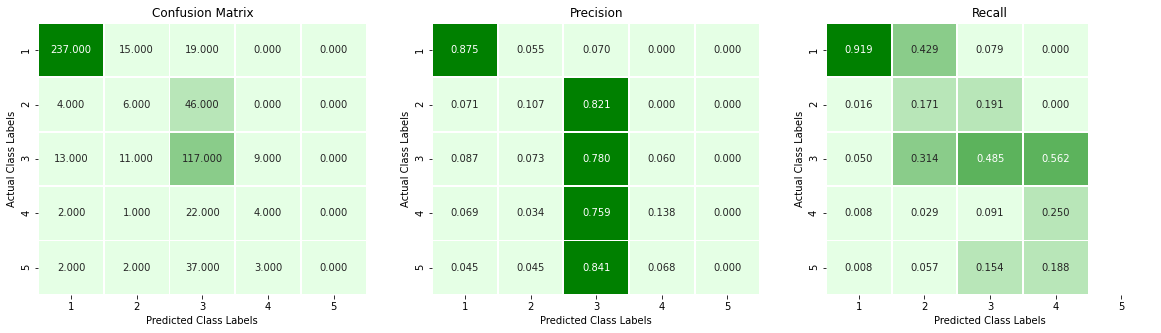

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%load_ext tensorboard 
%tensorboard --logdir="/content/drive/My Drive/baseline1" 

**Tensorboard Visualization**
<img src='https://imgur.com/y3uHu6V.png'>

### **AlexNet Architecture:**
<img src='https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-16-at-11.34.51-AM.png'>

**Highlights of Alexnet:**
1. Using Relu instead of Tanh to add non-linearity.
2. Local Response Normalization.
3. Overlapping Pooling.
4. Dropouts.
5. Training on Multiple GPU's<br>
i) Model Parallelism<br>
ii) Data Parallelism

In [ ]:
def AlexNet():
    ''' This function is used for building an alexnet architecture '''
    model = Sequential(name='alexnet') 
    model.add(Conv2D(96,(11,11),strides = (4,4), padding = 'valid', activation = 'relu', kernel_initializer = 'he_normal',input_shape = (512,512,3)))
    model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
    model.add(Conv2D(256, kernel_size = (5,5), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
    model.add(Conv2D(384, kernel_size = (3,3), padding = 'same', activation= 'relu'))
    model.add(Conv2D(384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
    model.add(Flatten()) 
    model.add(Dense(9216, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(2048, activation = 'relu')) 
    model.add(Dense(5, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
    return model

In [ ]:
alex_net = AlexNet()
alex_net.summary()

Model: "alexnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 96)      34944     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 96)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 62, 256)       614656    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 384)       885120    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 384)       1327488   
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 256)       8849

In [ ]:
kappa_metrics = Metrics('/content/drive/My Drive/models/alexnet.h5')
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/alexnet') 
call_backs = [kappa_metrics, tensorboard]
history = alex_net.fit(x_train, labels_train, epochs = 30, batch_size = 8, verbose = 2, validation_data = (x_validation, labels_validation), callbacks = call_backs)

Train on 3112 samples, validate on 550 samples
Epoch 1/30
 - 72s - loss: 2.1060 - accuracy: 0.7490 - val_loss: 0.4604 - val_accuracy: 0.8385
 - val_kappa:  0.3017

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/alexnet.h5...
Epoch 2/30
 - 71s - loss: 0.4699 - accuracy: 0.8148 - val_loss: 0.2935 - val_accuracy: 0.8949
 - val_kappa:  0.6671

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/alexnet.h5...
Epoch 3/30
 - 71s - loss: 0.3258 - accuracy: 0.8694 - val_loss: 0.2647 - val_accuracy: 0.8909
 - val_kappa:  0.5735

		Validation kappa did not improved from 0.6671219716063006
Epoch 4/30
 - 71s - loss: 0.2843 - accuracy: 0.8869 - val_loss: 0.2371 - val_accuracy: 0.9051
 - val_kappa:  0.6867

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/alexnet.h5...
Epoch 5/30
 - 71s - loss: 0.2610 - accuracy: 0.8973 - val_loss: 0.2348 - val_accuracy: 0.9076
 - val_kappa:  0.7236

		Validation Kappa ha

In [ ]:
alex_net = AlexNet()
alex_net.load_weights("/content/drive/My Drive/models/alexnet.h5")
result = alex_net.evaluate(x_validation,labels_validation)
y_pred = alex_net.predict(x_validation)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result[0],4),np.round(result[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

550/550 [==============================] - 6s 12ms/step
After running the model for 30 epochs we got loss = 0.2228 Accuracy = 0.9204 kappa_score = 0.7758 on validation data


In [ ]:
ytrain_alexnet = alex_net.predict(x_train)
ytrain_alexnet = test_prediction(ytrain_alexnet)
print("First five data points predictions in training:",ytrain_alexnet[45:50])
print("length of traindata prediction:",ytrain_alexnet.shape,"\n")

yvalidation_alexnet = alex_net.predict(x_validation)
yvalidation_alexnet = test_prediction(yvalidation_alexnet)
print("First five data points predictions in validation:",yvalidation_alexnet[45:50])
print("length of validation data prediction:",yvalidation_alexnet.shape,"\n")

ytest_alexnet = alex_net.predict(x_test)
ytest_alexnet = test_prediction(ytest_alexnet)
print("First five data points predictions in test:",ytest_alexnet[45:50])
print("length of test data prediction:",ytest_alexnet.shape)

First five data points predictions in training: [3 3 3 3 3]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [3 3 3 3 3]
length of validation data prediction: (550,) 

First five data points predictions in test: [3 3 3 3 3]
length of test data prediction: (1928,)


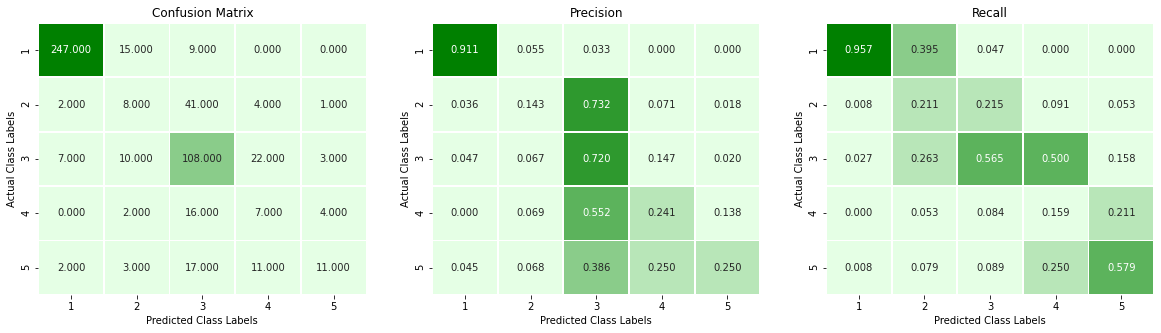

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="/content/drive/My Drive/alexnet"

**Tensorboard Visualization:**
<img src='https://imgur.com/ScQBfrw.png'>

### **Data Augmentation:**

We hardly have ~3k images on training and ~500 images for validation. Any deep learning model with small dataset will prone to overfit easily. 

By augmentation we can increase the size of our dataset at runtime without actually storing them in our system. I used the following four augmentation techniques which will increase our dataset by 4 times.
1.    horizontal flipping
2.    Vertical flipping
3.    rotation_range
4.    zoom range

Read more techniques of augmentation [here](https://towardsdatascience.com/data-augmentation-techniques-in-python-f216ef5eed69#:~:text=Basic%20data%20augmentation%20techniques%201%20Flipping%3A%20flipping%20the,in%2C%20Zoom%20out%206%20Changing%20brightness%20or%20contrast).

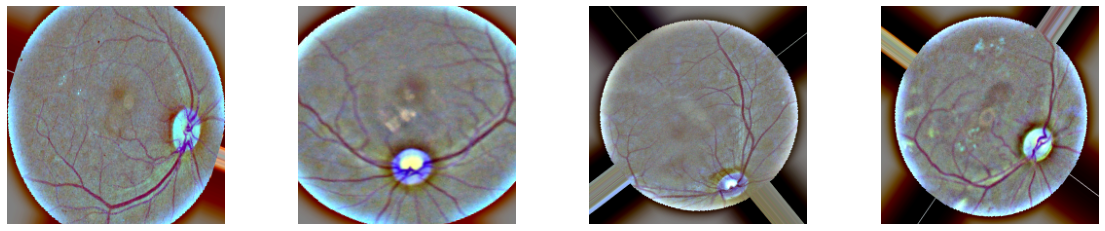

In [ ]:
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
it = 0
for x, y in data_generator.flow(x_train,train_labels):
    ax[it].imshow((x[0]).astype('uint8')) 
    ax[it].axis('off')
    it += 1
    if it == 4:
        break

In [ ]:
def GAP2D():
    '''Global average pooling layer'''
    global_average_pooling = GlobalAveragePooling2D()
    return global_average_pooling
def dropout(value = 0.5):
    '''Dropout layer'''
    dropout_layer = Dropout(value)
    return dropout_layer
def dense():
    '''Dense layer'''
    dense_layer = Dense(5, activation='sigmoid')
    return dense_layer

All the pretrained model architectures are extended with following three layers.
1.    **GlobalAveragePooling2D:**<br>
From the last convolutional layer of any pretained model which generates as many feature maps as the number of target classes, and applies global average pooling to each in order to convert each feature map into one value by taking average of it.
2.    **Dropout**<br>
Dropout works by randomly setting the outgoing edges of hidden units to 0 at each update of the training phase. Which will be used as a sort of regularization in order to avoid overfitting during model training.
3.    **Dense**<br>
This layer contains 5 units each represents the individual class with sigmoid activation.
<br>**Optimizer:** Adam<br>
**loss:** binary cross entropy<br>
**metric:** accuracy and weighted kappa <br>

### **Visual Geometry Group(VGG).**
*    VGG has 16 or 19 layers starting with simple 3x3 filters in first convolutional layer.
*    Number of channels increased with term of 2 and Nh, Nw decreased with factor of 2.
*    Though it contains lots of parameters, the model is simple with fixed 3x3 filters and stride=1 and same padding in convolutional layers.
*    2x2 filters with stride=2 in max pooling layers.


**VGG-16 architecture:**
<img src='https://neurohive.io/wp-content/uploads/2018/11/vgg16.png'/>


In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def VGG16_(top_6 = False):
    '''This function is used for building a model architecture of pretrained vgg16 on imagenet data set.'''
    vgg = VGG16(weights = 'imagenet', include_top = False, input_shape = (512,512,3))
    if not top_6:
        for layer in vgg.layers:
            layer.trainable = False
    else:
         for layer in vgg.layers[:13]:
            layer.trainable=False 
    x = global_average_pooling_layer(vgg.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(vgg.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
vgg16 = VGG16_(True)
vgg16.summary()

Model: "Vgg-16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 9,441,797
Non-trainable params: 5,275,456
_________________________________________________________________


>**Note:**<br>
<img src='https://imgur.com/9utoAfy.png' width=700px height=180px><br>
I used this architecture for printing summary which is actually different from the above in order to discard pretrained layers in summary section. But the actual results will be of same on using any architecture.

In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/vgg16')
kappa_metrics = Metrics('/content/drive/My Drive/models/vgg16.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
vgg16 = VGG16_(top_6 = True)
history = vgg16.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size=12), 
                    steps_per_epoch=len(x_train) / 12,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 12,
                    callbacks=[kappa_metrics,tensorboard])

Epoch 1/30
260/259 [==============================] - 42s 163ms/step - loss: 0.4320 - accuracy: 0.8418 - val_loss: 0.3015 - val_accuracy: 0.8898
 - val_kappa:  0.5891

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/vgg16.h5...
Epoch 2/30
260/259 [==============================] - 35s 134ms/step - loss: 0.2500 - accuracy: 0.9017 - val_loss: 0.2467 - val_accuracy: 0.9149
 - val_kappa:  0.7218

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/vgg16.h5...
Epoch 3/30
260/259 [==============================] - 35s 136ms/step - loss: 0.2234 - accuracy: 0.9116 - val_loss: 0.1838 - val_accuracy: 0.9335
 - val_kappa:  0.8043

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/vgg16.h5...
Epoch 4/30
260/259 [==============================] - 35s 134ms/step - loss: 0.1997 - accuracy: 0.9200 - val_loss: 0.2105 - val_accuracy: 0.9229
 - val_kappa:  0.7506

		Validation kappa did not improved from 0.80429

In [ ]:
vgg16 = VGG16_(top_6 = True)
vgg16.load_weights("/content/drive/My Drive/models/vgg16.h5")
result = vgg16.evaluate(x_validation,labels_validation)
y_pred = vgg16.predict(x_validation)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result[0],4),np.round(result[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

550/550 [==============================] - 9s 16ms/step
After running the model for 30 epochs we got loss = 0.1409 Accuracy = 0.9535 kappa_score = 0.8931 on validation data


In [ ]:
ytrain_vgg16 = vgg16.predict(x_train)
ytrain_vgg16 = test_prediction(ytrain_vgg16)
print("First five data points predictions in training:",ytrain_vgg16[:5])
print("length of traindata prediction:",ytrain_vgg16.shape,"\n")

yvalidation_vgg16 = vgg16.predict(x_validation)
yvalidation_vgg16 = test_prediction(yvalidation_vgg16)
print("First five data points predictions in validation:",yvalidation_vgg16[:5])
print("length of validation data prediction:",yvalidation_vgg16.shape,"\n")

ytest_vgg16 = vgg16.predict(x_test)
ytest_vgg16 = test_prediction(ytest_vgg16)
print("First five data points predictions in test:",ytest_vgg16[:5])
print("length of test data prediction:",ytest_vgg16.shape)

First five data points predictions in training: [0 2 0 2 2]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 0 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 2 3 2 2]
length of test data prediction: (1928,)


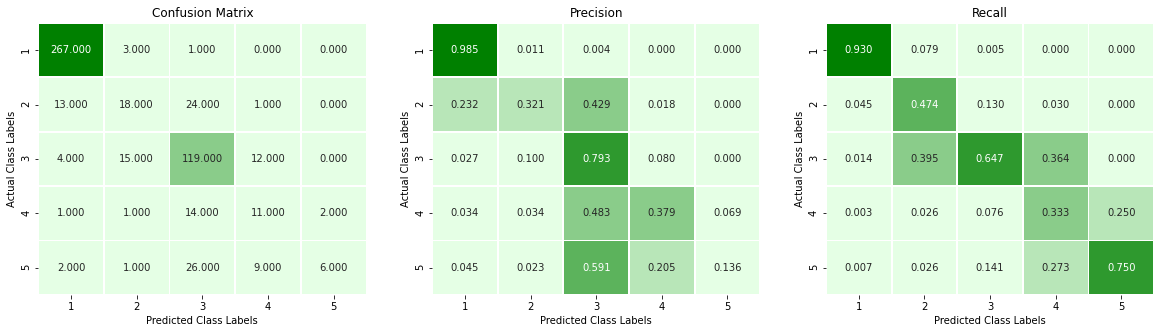

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/vgg16'

**Tensorboard Visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*Tm7ln5hd1eiC3ihBk0pJmA.png'>

**VGG-19 Architecture:**
<img src='https://raw.githubusercontent.com/FrancescoSaverioZuppichini/PytorchModuleStorage/master/images/vgg-19.png'/>

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def VGG19_(top_6 = False):
    '''This function is used for building a model architecture of pretrained Vgg19 on imagenet data set.'''
    vgg = VGG19(weights = 'imagenet', include_top = False, input_shape = (512,512,3))
    if not top_6:
        for layer in vgg.layers:
            layer.trainable = False
    else:
         for layer in vgg.layers[:13]:
            layer.trainable=False 
    x = global_average_pooling_layer(vgg.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(vgg.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
vgg19 = VGG19_(top_6 = True)
vgg19.summary()

Model: "Vgg-19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 16, 16, 512)       20024384  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 16,521,221
Non-trainable params: 3,505,728
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/models/vgg19')
kappa_metrics = Metrics('/content/drive/My Drive/vgg19.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
vgg19 = VGG19_(top_6 = True)
history = vgg19.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard], class_weight = class_weights)

80142336/80134624 [==============================] - 3s 0us/step
Epoch 1/30
  5/389 [..............................] - ETA: 1:24 - loss: 3.5918 - accuracy: 0.5250

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 41s 105ms/step - loss: 0.4839 - accuracy: 0.8208 - val_loss: 0.2136 - val_accuracy: 0.9167
 - val_kappa:  0.8014

		Validation Kappa has improved. Saving model to /content/drive/My Drive/vgg19.h5...
Epoch 2/30
389/389 [==============================] - 40s 102ms/step - loss: 0.2522 - accuracy: 0.9001 - val_loss: 0.1923 - val_accuracy: 0.9215
 - val_kappa:  0.8168

		Validation Kappa has improved. Saving model to /content/drive/My Drive/vgg19.h5...
Epoch 3/30
389/389 [==============================] - 40s 102ms/step - loss: 0.2256 - accuracy: 0.9104 - val_loss: 0.1720 - val_accuracy: 0.9353
 - val_kappa:  0.8326

		Validation Kappa has improved. Saving model to /content/drive/My Drive/vgg19.h5...
Epoch 4/30
389/389 [==============================] - 40s 102ms/step - loss: 0.2022 - accuracy: 0.9216 - val_loss: 0.1540 - val_accuracy: 0.9382
 - val_kappa:  0.8487

		Validation Kappa has improved. Saving model to /content/drive/My Drive/vgg19.h

In [ ]:
vgg19 = VGG19_(top_6 = True)
vgg19.load_weights("/content/drive/My Drive/vgg19.h5")
result = vgg19.evaluate(x_validation,labels_validation)
y_pred = vgg19.predict(x_validation)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result[0],4),np.round(result[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

550/550 [==============================] - 6s 11ms/step
After running the model for 30 epochs we got loss = 0.1102 Accuracy = 0.9575 kappa_score = 0.9128 on validation data


In [ ]:
ytrain_vgg19 = vgg19.predict(x_train)
ytrain_vgg19 = test_prediction(ytrain_vgg19)
print("First five data points predictions in training:",ytrain_vgg19[:5])
print("length of traindata prediction:",ytrain_vgg19.shape,"\n")

yvalidation_vgg19 = vgg19.predict(x_validation)
yvalidation_vgg19 = test_prediction(yvalidation_vgg19)
print("First five data points predictions in validation:",yvalidation_vgg19[:5])
print("length of validation data prediction:",yvalidation_vgg19.shape,"\n")

ytest_vgg19 = vgg19.predict(x_test)
ytest_vgg19 = test_prediction(ytest_vgg19)
print("First five data points predictions in test:",ytest_vgg19[:5])
print("length of test data prediction:",ytest_vgg19.shape)

First five data points predictions in training: [0 2 0 2 2]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 0 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 3 2 2 2]
length of test data prediction: (1928,)


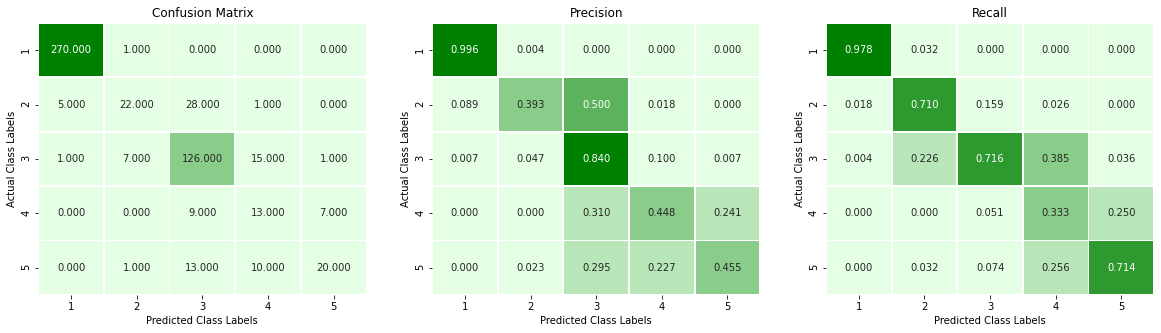

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/vgg19'

**Tensorboard Visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*63S0E7bEPlrEfl-wPTSKww.png'>

### **DenseNet Architecture:**

<img src='https://www.researchgate.net/publication/340662488/figure/fig1/AS:880794788696064@1587009250669/DenseNet-architecture-20.jpg'/>

*    Densenet was developed specifically to improve the declined accuracy caused by the vanishing gradient in in high-level neural networks.
*    Due to the longer path between the input and output layer, the information vanishes before reaching its destination.
*    It is a 5-layer dense block with a growth rate of k = 4.
*    An output of the previous layer acts as an input of the second layer by using composite function operation. This composite operation consists of the convolution layer, pooling layer, batch normalization, and non-linear activation layer.

**DenseNet with 121 layers:**

 => 5+(6+12+24+16)*2 = 121
*    5 - Convolutional and Pooling layer
*    3 - Transition layers(6,12,24)
*    1 - Classification layer(16)
*    2 - DenseBlock(1x1 and 3x3 conv)



In [33]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def DenseNet():
    '''This function is used for building a model architecture of pretrained Densenet121 on imagenet data set.'''
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(512,512,3))
    x = global_average_pooling_layer(densenet.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(densenet.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [17]:
densenet = DenseNet()
densenet.summary()

Model: "DenseNet-121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
densenet = DenseNet()
densenet.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "DenseNet-121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/densenet')
kappa_metrics = Metrics('/content/drive/My Drive/models/densenet.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
densenet = DenseNet()
history = densenet.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics, tensorboard], class_weight = class_weights)

Epoch 1/30
  2/389 [..............................] - ETA: 1:54:05 - loss: 0.8410 - accuracy: 0.5250

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.644158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 143s 367ms/step - loss: 0.3514 - accuracy: 0.8506 - val_loss: 0.1868 - val_accuracy: 0.9265
 - val_kappa:  0.7847

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/densenet.h5...
Epoch 2/30
389/389 [==============================] - 102s 263ms/step - loss: 0.2174 - accuracy: 0.9158 - val_loss: 0.1346 - val_accuracy: 0.9491
 - val_kappa:  0.8877

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/densenet.h5...
Epoch 3/30
389/389 [==============================] - 102s 262ms/step - loss: 0.1780 - accuracy: 0.9287 - val_loss: 0.1303 - val_accuracy: 0.9487
 - val_kappa:  0.8860

		Validation kappa did not improved from 0.8877281059701161
Epoch 4/30
389/389 [==============================] - 101s 260ms/step - loss: 0.1635 - accuracy: 0.9352 - val_loss: 0.1311 - val_accuracy: 0.9476
 - val_kappa:  0.8971

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/d

In [ ]:
densenet = DenseNet()
densenet.load_weights("/content/drive/My Drive/models/densenet.h5")
result = densenet.evaluate(x_validation,labels_validation)
y_pred = densenet.predict(x_validation)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result[0],4),np.round(result[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

550/550 [==============================] - 10s 17ms/step
After running the model for 30 epochs we got loss = 0.111 Accuracy = 0.9578 kappa_score = 0.923 on validation data


In [ ]:
ytrain_densenet = densenet.predict(x_train)
ytrain_densenet = test_prediction(ytrain_densenet)
print("First five data points predictions in training:",ytrain_densenet[:5])
print("length of traindata prediction:",ytrain_densenet.shape,"\n")

yvalidation_densenet = densenet.predict(x_validation)
yvalidation_densenet = test_prediction(yvalidation_densenet)
print("First five data points predictions in validation:",yvalidation_densenet[:5])
print("length of validation data prediction:",yvalidation_densenet.shape,"\n")

ytest_densenet = densenet.predict(x_test)
ytest_densenet = test_prediction(ytest_densenet)
print("First five data points predictions in test:",ytest_densenet[:5])
print("length of test data prediction:",ytest_densenet.shape)

First five data points predictions in training: [0 1 0 2 3]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 1 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 3 3 2 2]
length of test data prediction: (1928,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


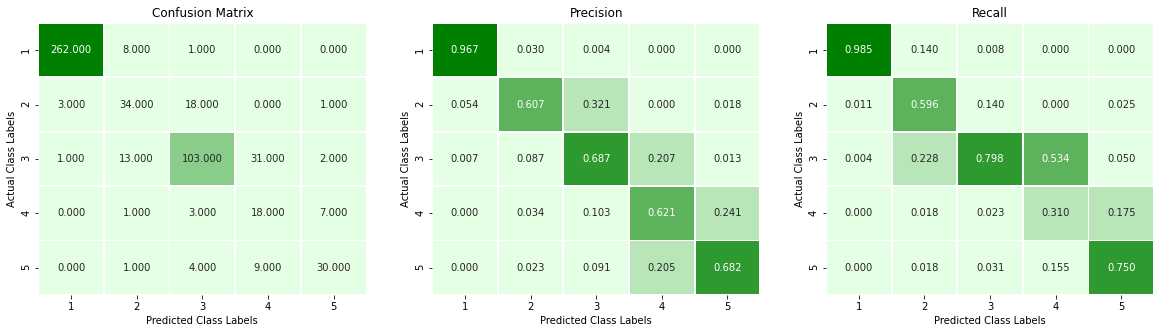

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/densenet'

<IPython.core.display.Javascript object>

**Tensorboard Visualization**
<img src='https://cdn-images-1.medium.com/max/1200/1*K25X9gOw9bd05wsz2WQQGQ.png'>

### **Residual Network:**

*    Instead of directly stacking few layers to fit an underlying H(x) mapping.Explicitly let these layers to fit a residual mapping F(x).<br>
Now,<br>
    F(x) = H(x) - x<br>
    H(x) = F(x) + x
    
    <img src='https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png'>
*    Now this residual mapping(F(x)+x) are called skip connections which skips one or more layers.
*    These connections perform identity mapping and there outputs are added to the outputs of the stacked layers.
*    These connections add neighter extra parameters nor computational complexity.

**Resnet-50 Architecture:**
<img src='https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/7b30817561c8aa87fa4d72ef6a75080000ef5ea0/6-Figure2-1.png'/>

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def ResNet50_():
    '''This function is used for building a model architecture of pretrained Resnet50 on imagenet data set.'''
    resnet = ResNet50(weights='imagenet',include_top=False,layers=keras.layers,input_shape=(512,512,3))
    x = global_average_pooling_layer(resnet.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(resnet.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
resnet = ResNet50_()
resnet.summary()

Model: "Resnet-50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/resnet50')
kappa_metrics = Metrics('/content/drive/My Drive/models/resnet50.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
resnet = ResNet50_()
history = resnet.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size = 8),
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard], class_weight = class_weights)

94773248/94765736 [==============================] - 4s 0us/step
Epoch 1/30
  3/389 [..............................] - ETA: 42:34 - loss: 0.8961 - accuracy: 0.4333

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.841238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 86s 220ms/step - loss: 0.4265 - accuracy: 0.8000 - val_loss: 0.2152 - val_accuracy: 0.9200
 - val_kappa:  0.7633

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/resnet50.h5...
Epoch 2/30
389/389 [==============================] - 64s 165ms/step - loss: 0.2450 - accuracy: 0.9027 - val_loss: 0.1651 - val_accuracy: 0.9364
 - val_kappa:  0.8196

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/resnet50.h5...
Epoch 3/30
389/389 [==============================] - 64s 164ms/step - loss: 0.2063 - accuracy: 0.9179 - val_loss: 0.1475 - val_accuracy: 0.9422
 - val_kappa:  0.8489

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/resnet50.h5...
Epoch 4/30
389/389 [==============================] - 64s 164ms/step - loss: 0.1914 - accuracy: 0.9228 - val_loss: 0.1340 - val_accuracy: 0.9462
 - val_kappa:  0.8736

		Validation Kappa has improved. Saving model to /

In [ ]:
resnet = ResNet50_()
resnet.load_weights("/content/drive/My Drive/models/resnet50.h5")
result = resnet.evaluate(x_validation,labels_validation)
y_pred = resnet.predict(x_validation)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result[0],4),np.round(result[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

550/550 [==============================] - 7s 13ms/step
After running the model for 30 epochs we got loss = 0.1264 Accuracy = 0.9567 kappa_score = 0.9091 on validation data


In [ ]:
ytrain_resnet = resnet.predict(x_train)
ytrain_resnet = test_prediction(ytrain_resnet)
print("First five data points predictions in training:",ytrain_resnet[:5])
print("length of traindata prediction:",ytrain_resnet.shape,"\n")

yvalidation_resnet = resnet.predict(x_validation)
yvalidation_resnet = test_prediction(yvalidation_resnet)
print("First five data points predictions in validation:",yvalidation_resnet[:5])
print("length of validation data prediction:",yvalidation_resnet.shape,"\n")

ytest_resnet = resnet.predict(x_test)
ytest_resnet = test_prediction(ytest_resnet)
print("First five data points predictions in test:",ytest_resnet[:5])
print("length of test data prediction:",ytest_resnet.shape)

First five data points predictions in training: [0 2 0 2 1]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 0 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 2 3 2 3]
length of test data prediction: (1928,)


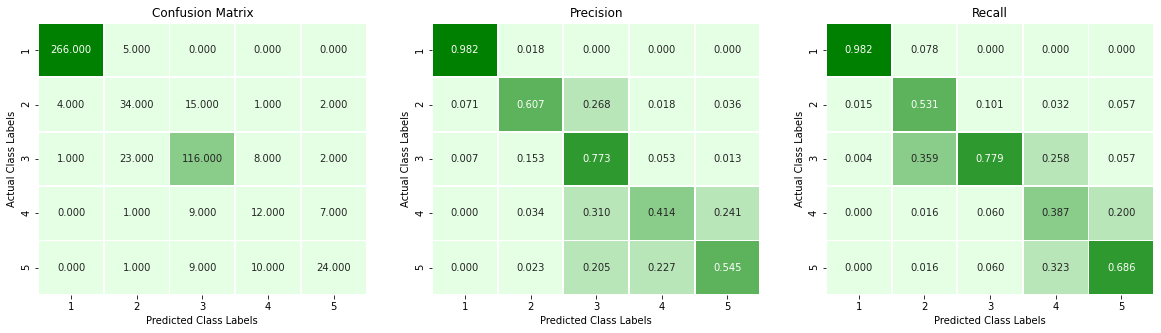

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/resnet50'

**Tensorboard visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*Y3W4ZcH23DksLfNEdmGURw.png'>

**Resnet-152 Architecture:**
<img src='https://miro.medium.com/max/1200/1*S-8Te9IM9tKNznzGJ1JnmQ.png'/>

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def ResNet152_():
    '''This function is used for building a model architecture of pretrained Resnet152 on imagenet data set.'''
    resnet = ResNet152(weights='imagenet',include_top=False,layers=keras.layers,input_shape=(512,512,3))
    x = global_average_pooling_layer(resnet.layers[-1].output)
    x = dropout_layer(x) 
    output = dense_layer(x)
    model = Model(resnet.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
resnet = ResNet152_()
resnet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 16, 16, 2048)      58370944  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 10245     
Total params: 58,381,189
Trainable params: 58,229,765
Non-trainable params: 151,424
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/resnet152')
kappa_metrics = Metrics('/content/drive/My Drive/models/resnet152.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
resnet = ResNet152_()
history = resnet.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size = 8),
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard], class_weight = class_weights)

Epoch 1/30
  2/389 [..............................] - ETA: 3:43:34 - loss: 0.9010 - accuracy: 0.4250

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.943490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 219s 564ms/step - loss: 0.3880 - accuracy: 0.8213 - val_loss: 0.1875 - val_accuracy: 0.9258
 - val_kappa:  0.7848

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/resnet152.h5...
Epoch 2/30
389/389 [==============================] - 144s 371ms/step - loss: 0.2126 - accuracy: 0.9134 - val_loss: 0.1499 - val_accuracy: 0.9385
 - val_kappa:  0.8364

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/resnet152.h5...
Epoch 3/30
389/389 [==============================] - 145s 373ms/step - loss: 0.1854 - accuracy: 0.9248 - val_loss: 0.1398 - val_accuracy: 0.9440
 - val_kappa:  0.8654

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/resnet152.h5...
Epoch 4/30
389/389 [==============================] - 146s 374ms/step - loss: 0.1720 - accuracy: 0.9308 - val_loss: 0.1308 - val_accuracy: 0.9480
 - val_kappa:  0.8818

		Validation Kappa has improved. Saving mod

In [ ]:
resnet = ResNet152_()
resnet.load_weights("/content/drive/My Drive/models/resnet152.h5")
result = resnet.evaluate(x_validation,labels_validation)
y_pred = resnet.predict(x_validation)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result[0],4),np.round(result[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

550/550 [==============================] - 19s 34ms/step
After running the model for 30 epochs we got loss = 0.1164 Accuracy = 0.9585 kappa_score = 0.9146 on validation data


In [ ]:
ytrain_resnet1 = resnet.predict(x_train)
ytrain_resnet1 = test_prediction(ytrain_resnet1)
print("First five data points predictions in training:",ytrain_resnet1[:5])
print("length of traindata prediction:",ytrain_resnet1.shape,"\n")

yvalidation_resnet1 = resnet.predict(x_validation)
yvalidation_resnet1 = test_prediction(yvalidation_resnet1)
print("First five data points predictions in validation:",yvalidation_resnet1[:5])
print("length of validation data prediction:",yvalidation_resnet1.shape,"\n")

ytest_resnet1 = resnet.predict(x_test)
ytest_resnet1 = test_prediction(ytest_resnet1)
print("First five data points predictions in test:",ytest_resnet1[:5])
print("length of test data prediction:",ytest_resnet1.shape)

First five data points predictions in training: [0 1 0 2 2]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 0 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 2 2 2 2]
length of test data prediction: (1928,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


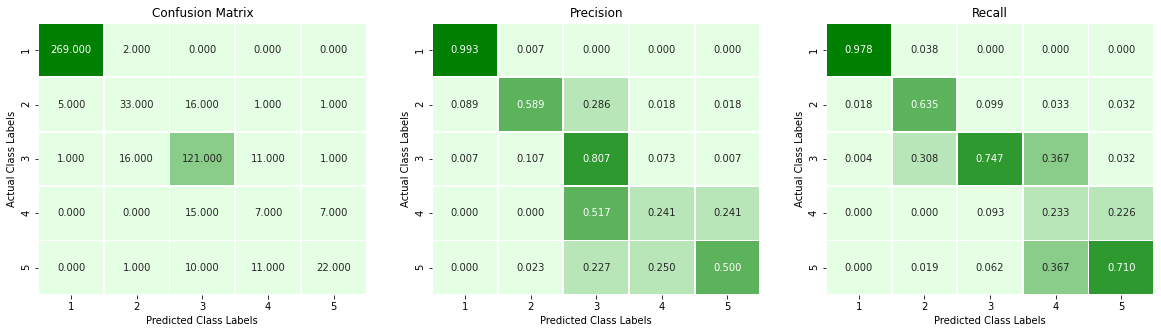

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/resnet152'

**Tensorboard Visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*R_M8gYsTvP5xwlpkpZyhwQ.png'>

### **Inception Networks:**
*    Inception model allows us to apply multiple filters(1x1, 3x3, 5x5) and even max pooling layer on the same level and concatenate the results. Thus the network essentially would get a bit 'wider' rather than 'deeper'.

**Inception module:**

<img src='https://cdn-images-1.medium.com/max/1600/1*U_McJnp7Fnif-lw9iIC5Bw.png' width=360px>

**Inception v3 Architecture:**
<img src='https://alexisbcook.github.io/assets/inception.png'/>



In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def inceptionv3_():
    '''This function is used for building a model architecture of pretrained InceptionV3 on imagenet data set.'''
    inceptionv3 = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (512,512,3))
    x = global_average_pooling_layer(inceptionv3.layers[-1].output)
    x = dropout_layer(x) 
    output = dense_layer(x) 
    model = Model(inceptionv3.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
inceptionv3 = inceptionv3_()
inceptionv3.summary()

Model: "inception-v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/inceptionv3')
kappa_metrics = Metrics('/content/drive/My Drive/models/inceptionv3.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
inceptionv3 = inceptionv3_()
history = inceptionv3.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size = 8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard],class_weight = class_weights)

87916544/87910968 [==============================] - 3s 0us/step
Epoch 1/30
  3/389 [..............................] - ETA: 58:11 - loss: 0.8915 - accuracy: 0.3583  

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (3.077288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 101s 258ms/step - loss: 0.5048 - accuracy: 0.7531 - val_loss: 0.2687 - val_accuracy: 0.9033
 - val_kappa:  0.6694

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/inceptionv3.h5...
Epoch 2/30
389/389 [==============================] - 71s 183ms/step - loss: 0.2789 - accuracy: 0.8956 - val_loss: 0.2201 - val_accuracy: 0.9116
 - val_kappa:  0.6890

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/inceptionv3.h5...
Epoch 3/30
389/389 [==============================] - 71s 183ms/step - loss: 0.2328 - accuracy: 0.9093 - val_loss: 0.2010 - val_accuracy: 0.9175
 - val_kappa:  0.7267

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/inceptionv3.h5...
Epoch 4/30
389/389 [==============================] - 72s 185ms/step - loss: 0.2178 - accuracy: 0.9135 - val_loss: 0.1808 - val_accuracy: 0.9244
 - val_kappa:  0.7676

		Validation Kappa has improved. Saving 

In [ ]:
inceptionv3 = inceptionv3_()
inceptionv3.load_weights("/content/drive/My Drive/models/inceptionv3.h5")
result1 = inceptionv3.evaluate(x_validation,labels_validation, verbose = 2)
y_pred = inceptionv3.predict(x_validation, batch_size = 8)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result1[0],4),np.round(result1[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

After running the model for 30 epochs we got loss = 0.1204 Accuracy = 0.9545 kappa_score = 0.9014 on validation data


In [ ]:
ytrain_inception = inceptionv3.predict(x_train)
ytrain_inception = test_prediction(ytrain_inception)
print("First five data points predictions in training:",ytrain_inception[:5])
print("length of traindata prediction:",ytrain_inception.shape,"\n")

yvalidation_inception = inceptionv3.predict(x_validation)
yvalidation_inception = test_prediction(yvalidation_inception)
print("First five data points predictions in validation:",yvalidation_inception[:5])
print("length of validation data prediction:",yvalidation_inception.shape,"\n")

ytest_inception = inceptionv3.predict(x_test)
ytest_inception = test_prediction(ytest_inception)
print("First five data points predictions in test:",ytest_inception[:5])
print("length of test data prediction:",ytest_inception.shape)

First five data points predictions in training: [0 2 0 2 2]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 1 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 2 2 1 3]
length of test data prediction: (1928,)


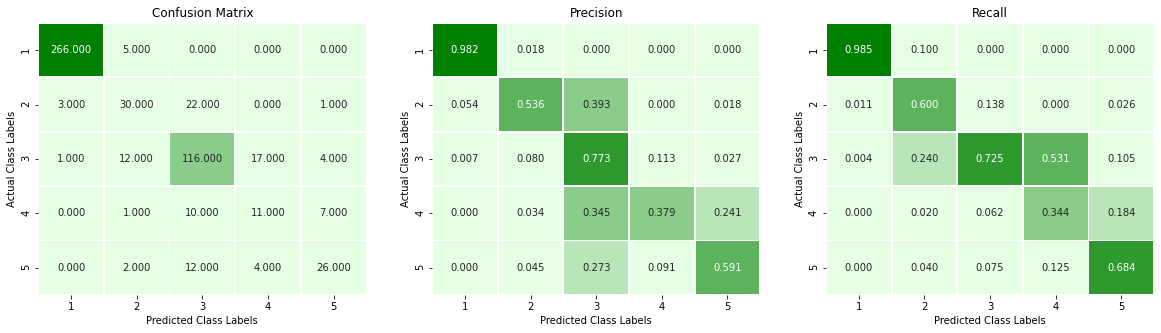

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/inceptionv3'

**Tensorboard Visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*P_yEzb8dqA5EMbl-ahaELw.png'>

In [ ]:
pip install efficientnet

### **EfficientNet Networks:**

*    It starts with stem.
<img src='https://imgur.com/xPSFkGz.png'/>
*    Generally, the models are made too wide, deep, or with a very high resolution. Increasing these characteristics helps the model initially but it quickly saturates and the model made just has more parameters and is therefore not efficient. In EfficientNet they are scaled in a more principled way i.e. gradually everything is increased.
*    The architecture consists of 7 blocks. These blocks further have a varying number of sub-blocks whose number is increased.
*    Finally ends with Final layers.

<img src='https://imgur.com/ZNZUxqK.png' width=400px height=50px/>

Read more about efficientnet [here](https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142).

**EfficientNet-B0 Architecture:**
<img src='https://miro.medium.com/max/1500/1*rnhgFRXetwD8PvxhZIpwIA.png'>

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def efficientnet_b0():
    '''This function is used for building a model architecture of pretrained EfficientB0 on imagenet data set.'''
    efficientnet_ = EfficientNetB0(weights = 'imagenet',include_top = False, input_shape = (512,512,3))
    x = global_average_pooling_layer(efficientnet_.layers[-1].output)
    x = dropout_layer(x) 
    output = dense_layer(x) 
    model = Model(efficientnet_.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
efficientnet_ = efficientnet_b0()
efficientnet_.summary()

Model: "Efficientnet-B0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 16, 16, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d_13  (None, 1280)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/efficientnet_b0')
kappa_metrics = Metrics('/content/drive/My Drive/models/efficientnet_b0.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
efficientnet_ = efficientnet_b0()
history = efficientnet_.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size = 8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard], class_weight = class_weights)

Epoch 1/30
  3/389 [..............................] - ETA: 43:21 - loss: 0.6731 - accuracy: 0.5833

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.638426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 89s 229ms/step - loss: 0.3607 - accuracy: 0.8567 - val_loss: 0.2652 - val_accuracy: 0.8876
 - val_kappa:  0.5778

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b0.h5...
Epoch 2/30
389/389 [==============================] - 67s 173ms/step - loss: 0.2073 - accuracy: 0.9193 - val_loss: 0.2083 - val_accuracy: 0.9102
 - val_kappa:  0.6983

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b0.h5...
Epoch 3/30
389/389 [==============================] - 67s 171ms/step - loss: 0.1832 - accuracy: 0.9271 - val_loss: 0.1813 - val_accuracy: 0.9251
 - val_kappa:  0.7688

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b0.h5...
Epoch 4/30
389/389 [==============================] - 67s 171ms/step - loss: 0.1697 - accuracy: 0.9328 - val_loss: 0.1733 - val_accuracy: 0.9342
 - val_kappa:  0.8310

		Validation Kappa has improv

In [ ]:
efficientnet_ = efficientnet_b0()
efficientnet_.load_weights("/content/drive/My Drive/models/efficientnet_b0.h5")
result1 = efficientnet_.evaluate(x_validation,labels_validation, verbose = 2)
y_pred = efficientnet_.predict(x_validation, batch_size = 8)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result1[0],4),np.round(result1[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

After running the model for 30 epochs we got loss = 0.1178 Accuracy = 0.9593 kappa_score = 0.9144 on validation data


In [ ]:
ytrain_efficientb0 = efficientnet_.predict(x_train)
ytrain_efficientb0 = test_prediction(ytrain_efficientb0)
print("First five data points predictions in training:",ytrain_efficientb0[:5])
print("length of traindata prediction:",ytrain_efficientb0.shape,"\n")

yvalidation_efficientb0 = efficientnet_.predict(x_validation)
yvalidation_efficientb0 = test_prediction(yvalidation_efficientb0)
print("First five data points predictions in validation:",yvalidation_efficientb0[:5])
print("length of validation data prediction:",yvalidation_efficientb0.shape,"\n")

ytest_efficientb0 = efficientnet_.predict(x_test)
ytest_efficientb0 = test_prediction(ytest_efficientb0)
print("First five data points predictions in test:",ytest_efficientb0[:5])
print("length of test data prediction:",ytest_efficientb0.shape)

First five data points predictions in training: [0 1 0 2 3]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 1 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 3 2 2 2]
length of test data prediction: (1928,)


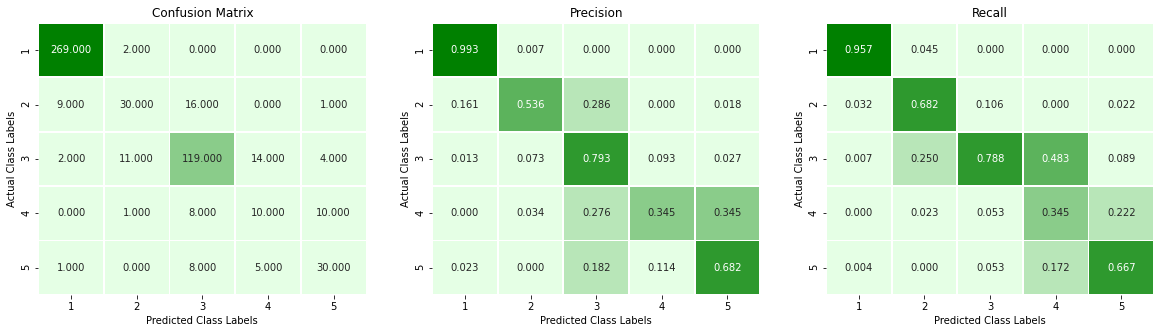

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/efficientnet_b0'

**Tensorboard Visualization**
<img src='https://cdn-images-1.medium.com/max/1200/1*ZcKpnBxu822X38naga7EPw.png'>

**EfficientNet-B3 Architecture:**

<img src='https://miro.medium.com/max/1500/1*8oE4jOMfOXeEzgsHjSB5ww.png'>

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def efficientnet_b3():
    '''This function is used for building a model architecture of pretrained EfficientB3 on imagenet data set.'''
    efficientnet_ = EfficientNetB3(weights = 'imagenet',include_top = False, input_shape = (512,512,3) )
    x = global_average_pooling_layer(efficientnet_.layers[-1].output)
    x = dropout_layer(x) 
    output = dense_layer(x) 
    model = Model(efficientnet_.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
efficientnet_ = efficientnet_b3()
efficientnet_.summary()

Model: "Efficientnet-B3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Functional) (None, 16, 16, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_15  (None, 1536)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 7685      
Total params: 10,791,213
Trainable params: 10,703,917
Non-trainable params: 87,296
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/efficientnet_b3')
kappa_metrics = Metrics('/content/drive/My Drive/models/efficientnet_b3.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
efficientnet_ = efficientnet_b3()
history = efficientnet_.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size = 8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard], class_weight = class_weights)

44113920/44107200 [==============================] - 2s 0us/step
Epoch 1/30
  2/389 [..............................] - ETA: 1:38:05 - loss: 0.8306 - accuracy: 0.3250

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (2.143740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 143s 367ms/step - loss: 0.3380 - accuracy: 0.8572 - val_loss: 0.1959 - val_accuracy: 0.9200
 - val_kappa:  0.7555

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b3.h5...
Epoch 2/30
389/389 [==============================] - 107s 275ms/step - loss: 0.1958 - accuracy: 0.9227 - val_loss: 0.1531 - val_accuracy: 0.9396
 - val_kappa:  0.8484

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b3.h5...
Epoch 3/30
389/389 [==============================] - 107s 274ms/step - loss: 0.1682 - accuracy: 0.9329 - val_loss: 0.1491 - val_accuracy: 0.9436
 - val_kappa:  0.8543

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b3.h5...
Epoch 4/30
389/389 [==============================] - 108s 276ms/step - loss: 0.1563 - accuracy: 0.9381 - val_loss: 0.1317 - val_accuracy: 0.9487
 - val_kappa:  0.8728

		Validation Kappa has im

In [ ]:
efficientnet_ = efficientnet_b3()
efficientnet_.load_weights("/content/drive/My Drive/models/efficientnet_b3.h5")
result1 = efficientnet_.evaluate(x_validation,labels_validation, verbose = 2)
y_pred = efficientnet_.predict(x_validation, batch_size = 8)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result1[0],4),np.round(result1[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

After running the model for 30 epochs we got loss = 0.1048 Accuracy = 0.9615 kappa_score = 0.9199 on validation data


In [ ]:
ytrain_efficientb1 = efficientnet_.predict(x_train)
ytrain_efficientb1 = test_prediction(ytrain_efficientb1)
print("First five data points predictions in training:",ytrain_efficientb1[:5])
print("length of traindata prediction:",ytrain_efficientb1.shape,"\n")

yvalidation_efficientb1 = efficientnet_.predict(x_validation)
yvalidation_efficientb1 = test_prediction(yvalidation_efficientb1)
print("First five data points predictions in validation:",yvalidation_efficientb1[:5])
print("length of validation data prediction:",yvalidation_efficientb1.shape,"\n")

ytest_efficientb1 = efficientnet_.predict(x_test)
ytest_efficientb1 = test_prediction(ytest_efficientb1)
print("First five data points predictions in test:",ytest_efficientb1[:5])
print("length of test data prediction:",ytest_efficientb1.shape)

First five data points predictions in training: [0 1 0 2 3]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 1 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 3 2 2 2]
length of test data prediction: (1928,)


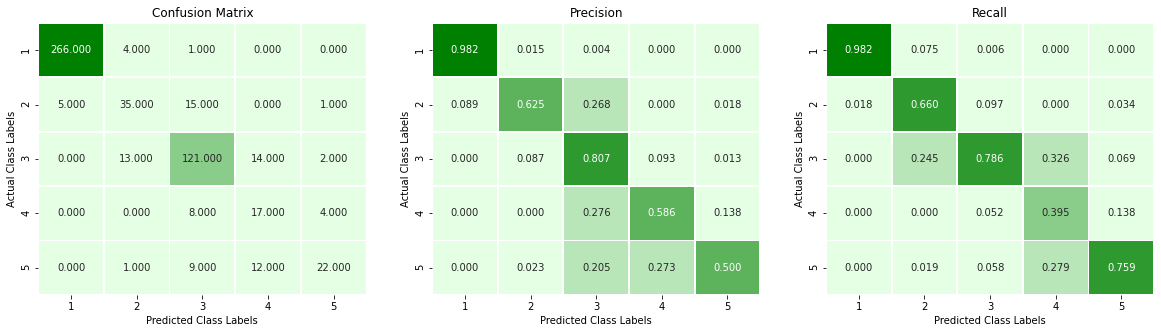

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/efficientnet_b3'

**Tensorboard Visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*5dHrrK4xfaiGrjKxs8E0JQ.png'>

**EfficientNet-B4:**

<img src='https://miro.medium.com/max/1500/1*4-w-cb0WpFb4pBdf6ZCA7w.png'>

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def efficientnet_b4():
    '''This function is used for building a model architecture of pretrained EfficientB4 on imagenet data set.'''
    efficientnet_ = EfficientNetB4(weights = 'imagenet',include_top = False, input_shape = (512,512,3) )
    x = global_average_pooling_layer(efficientnet_.layers[-1].output)
    x = dropout_layer(x) 
    output = dense_layer(x) 
    model = Model(efficientnet_.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
efficientnet_ = efficientnet_b4()
efficientnet_.summary()

Model: "Efficientnet-B4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 16, 16, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d_17  (None, 1792)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 1792)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/efficientnet_b4')
kappa_metrics = Metrics('/content/drive/My Drive/models/efficientnet_b4.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
efficientnet_ = efficientnet_b4()
history = efficientnet_.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size = 8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard], class_weight = class_weights)

Epoch 1/30
  2/389 [..............................] - ETA: 2:16:54 - loss: 0.7094 - accuracy: 0.4750

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.670378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 175s 449ms/step - loss: 0.3441 - accuracy: 0.8629 - val_loss: 0.1866 - val_accuracy: 0.9244
 - val_kappa:  0.7598

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b4.h5...
Epoch 2/30
389/389 [==============================] - 128s 329ms/step - loss: 0.1906 - accuracy: 0.9264 - val_loss: 0.1494 - val_accuracy: 0.9404
 - val_kappa:  0.8374

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b4.h5...
Epoch 3/30
389/389 [==============================] - 129s 331ms/step - loss: 0.1707 - accuracy: 0.9334 - val_loss: 0.1347 - val_accuracy: 0.9440
 - val_kappa:  0.8634

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/efficientnet_b4.h5...
Epoch 4/30
389/389 [==============================] - 129s 331ms/step - loss: 0.1527 - accuracy: 0.9400 - val_loss: 0.1338 - val_accuracy: 0.9480
 - val_kappa:  0.8702

		Validation Kappa has im

In [ ]:
efficientnet_ = efficientnet_b4()
efficientnet_.load_weights("/content/drive/My Drive/models/efficientnet_b4.h5")
result1 = efficientnet_.evaluate(x_validation,labels_validation, verbose = 2)
y_pred = efficientnet_.predict(x_validation, batch_size = 8)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result1[0],4),np.round(result1[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

After running the model for 30 epochs we got loss = 0.1198 Accuracy = 0.96 kappa_score = 0.9193 on validation data


In [ ]:
ytrain_efficientb2 = efficientnet_.predict(x_train)
ytrain_efficientb2 = test_prediction(ytrain_efficientb2)
print("First five data points predictions in training:",ytrain_efficientb2[:5])
print("length of traindata prediction:",ytrain_efficientb2.shape,"\n")

yvalidation_efficientb2 = efficientnet_.predict(x_validation)
yvalidation_efficientb2 = test_prediction(yvalidation_efficientb2)
print("First five data points predictions in validation:",yvalidation_efficientb2[:5])
print("length of validation data prediction:",yvalidation_efficientb2.shape,"\n")

ytest_efficientb2 = efficientnet_.predict(x_test)
ytest_efficientb2 = test_prediction(ytest_efficientb2)
print("First five data points predictions in test:",ytest_efficientb2[:5])
print("length of test data prediction:",ytest_efficientb2.shape)

First five data points predictions in training: [0 1 0 2 2]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 1 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [1 3 3 2 3]
length of test data prediction: (1928,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


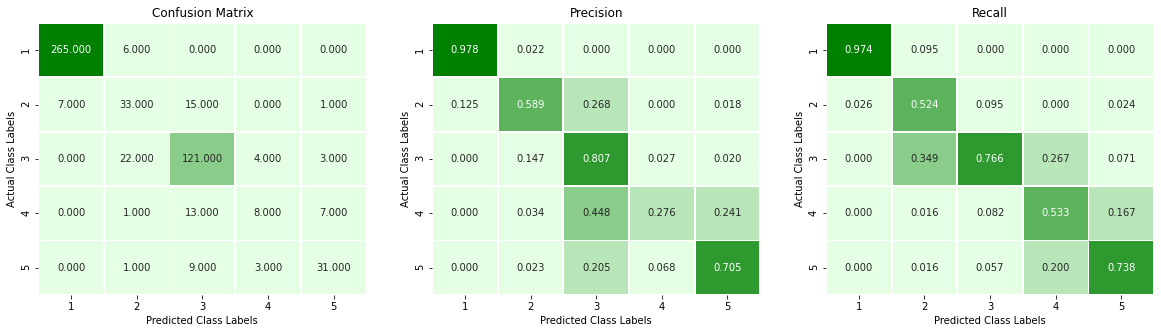

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/efficientnet_b4'

**Tensorboard Visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*JVY8giQ3kVJ-xlPppfuNVg.png'>

### **Xception Architecture:**

<img src='https://imgur.com/JCLa5IB.png'>

XCeption is an efficient architecture that relies on two main points :

*   Depthwise Separable Convolution: <br>
To overcome the cost of such operations, depthwise separable convolutions have been introduced. <br>
They are themselves divided into 2 main steps :

    1.   Depthwise Convolution
    2.   Pointwise Convolution
*   Shortcuts between Convolution blocks as in ResNet:<br>
These are skip connections which are introduced in Resnet.

Read more about Xception net [here](https://maelfabien.github.io/deeplearning/xception/#ii-in-keras).

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

In [ ]:
def xception():
    '''This function is used for building a model architecture of pretrained Xception on imagenet data set.'''
    xception_ = Xception(weights = 'imagenet',include_top = False, input_shape = (512,512,3) )
    x = global_average_pooling_layer(xception_.layers[-1].output)
    x = dropout_layer(x) 
    output = dense_layer(x) 
    model = Model(xception_.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
xception_ = xception()
xception_.summary()

Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_19  (None, 2048)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/xception')
kappa_metrics = Metrics('/content/drive/My Drive/models/xception.h5')
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
xception_ = xception()
history = xception_.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size = 8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[kappa_metrics,tensorboard], class_weight = class_weights)

83689472/83683744 [==============================] - 3s 0us/step
Epoch 1/30
  3/389 [..............................] - ETA: 28:37 - loss: 0.6218 - accuracy: 0.7167

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.466768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/389 [==============================] - 90s 231ms/step - loss: 0.2971 - accuracy: 0.8906 - val_loss: 0.1630 - val_accuracy: 0.9404
 - val_kappa:  0.8357

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/xception.h5...
Epoch 2/30
389/389 [==============================] - 76s 195ms/step - loss: 0.1871 - accuracy: 0.9265 - val_loss: 0.1628 - val_accuracy: 0.9342
 - val_kappa:  0.8622

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/xception.h5...
Epoch 3/30
389/389 [==============================] - 76s 195ms/step - loss: 0.1653 - accuracy: 0.9335 - val_loss: 0.1320 - val_accuracy: 0.9509
 - val_kappa:  0.8756

		Validation Kappa has improved. Saving model to /content/drive/My Drive/models/xception.h5...
Epoch 4/30
389/389 [==============================] - 76s 195ms/step - loss: 0.1512 - accuracy: 0.9409 - val_loss: 0.1329 - val_accuracy: 0.9498
 - val_kappa:  0.8734

		Validation kappa did not improved from 0.8755509

In [ ]:
xception_ = xception()
xception_.load_weights("/content/drive/My Drive/models/xception.h5")
result1 = xception_.evaluate(x_validation,labels_validation, verbose = 2)
y_pred = xception_.predict(x_validation, batch_size = 8)
print("After running the model for 30 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result1[0],4),np.round(result1[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))

After running the model for 30 epochs we got loss = 0.1071 Accuracy = 0.9575 kappa_score = 0.9161 on validation data


In [ ]:
ytrain_xception = xception_.predict(x_train)
ytrain_xception = test_prediction(ytrain_xception)
print("First five data points predictions in training:",ytrain_xception[:5])
print("length of traindata prediction:",ytrain_xception.shape,"\n")

yvalidation_xception = xception_.predict(x_validation)
yvalidation_xception = test_prediction(yvalidation_xception)
print("First five data points predictions in validation:",yvalidation_xception[:5])
print("length of validation data prediction:",yvalidation_xception.shape,"\n")

ytest_xception = xception_.predict(x_test)
ytest_xception = test_prediction(ytest_xception)
print("First five data points predictions in test:",ytest_xception[:5])
print("length of test data prediction:",ytest_xception.shape)

First five data points predictions in training: [0 1 0 2 2]
length of traindata prediction: (3112,) 

First five data points predictions in validation: [0 0 0 1 4]
length of validation data prediction: (550,) 

First five data points predictions in test: [2 3 2 2 2]
length of test data prediction: (1928,)


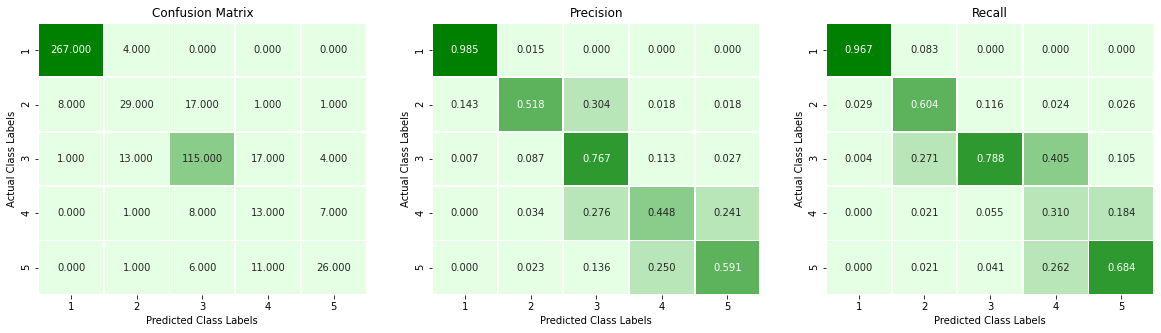

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/xception'

**Tensorboard Visualization:**
<img src='https://cdn-images-1.medium.com/max/1200/1*mAMuFmXMr3kTFBHMFSo8Ew.png'>

**Saving Files for further tasks:**

In [ ]:
train_predictions = pd.DataFrame(ytrain_baseline, columns=['baseline'])
train_predictions['alexnet']=ytrain_alexnet
train_predictions['vgg16']=ytrain_vgg16
train_predictions['vgg19']=ytrain_vgg19
train_predictions['densenet']=ytrain_densenet
train_predictions['resnet']=ytrain_resnet
train_predictions['resnet1']=ytrain_resnet1
train_predictions['inception']=ytrain_inception
train_predictions['efficientb0']=ytrain_efficientb0
train_predictions['efficientb1']=ytrain_efficientb1
train_predictions['efficientb2']=ytrain_efficientb2
train_predictions['xception']=ytrain_xception
train_predictions['label']=train_labels
train_predictions.head(3)

,baseline,alexnet,vgg16,vgg19,densenet,resnet,resnet1,inception,efficientb0,efficientb1,efficientb2,xception,label
0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,2,3,2,2,1,2,1,2,1,1,1,1,1
2,0,3,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
validation_predictions = pd.DataFrame(yvalidation_baseline, columns=['baseline'])
validation_predictions['alexnet']=yvalidation_alexnet
validation_predictions['vgg16']=yvalidation_vgg16
validation_predictions['vgg19']=yvalidation_vgg19
validation_predictions['densenet']=yvalidation_densenet
validation_predictions['resnet']=yvalidation_resnet
validation_predictions['resnet1']=yvalidation_resnet1
validation_predictions['inception']=yvalidation_inception
validation_predictions['efficientb0']=yvalidation_efficientb0
validation_predictions['efficientb1']=yvalidation_efficientb1
validation_predictions['efficientb2']=yvalidation_efficientb2
validation_predictions['xception']=yvalidation_xception
validation_predictions['label']=validation_labels
validation_predictions.head(3)

,baseline,alexnet,vgg16,vgg19,densenet,resnet,resnet1,inception,efficientb0,efficientb1,efficientb2,xception,label
0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,0,0,0,0,0,0
2,2,3,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_predictions = pd.DataFrame(ytest_baseline, columns=['baseline'])
test_predictions['alexnet']=ytest_alexnet
test_predictions['vgg16']=ytest_vgg16
test_predictions['vgg19']=ytest_vgg19
test_predictions['densenet']=ytest_densenet
test_predictions['resnet']=ytest_resnet
test_predictions['resnet1']=ytest_resnet1
test_predictions['inception']=ytest_inception
test_predictions['efficientb0']=ytest_efficientb0
test_predictions['efficientb1']=ytest_efficientb1
test_predictions['efficientb2']=ytest_efficientb2
test_predictions['xception']=ytest_xception
test_predictions.head(3)

,baseline,alexnet,vgg16,vgg19,densenet,resnet,resnet1,inception,efficientb0,efficientb1,efficientb2,xception
0,1,3,1,1,1,1,1,1,1,1,1,2
1,3,3,2,3,3,2,2,2,3,3,3,3
2,2,3,3,2,3,3,2,2,2,2,3,2


# **Ensembles:**

Taking N model predictions and taking the max count of labels as class predictions.<br/>
E.g: [1,0,0,1,1,1,2] will be predicted as 1 since 4 models predicted as 1, 2 models as 0 and 1 model as 2.<br> 
Hence the class prediction = max count of labels i.e.,1

<img src='https://imgur.com/bXG7iid.png' width=600px height=300px/>



In [ ]:
def ensembling(df):

    '''
    This process performs ensembling of all pretrained model predictions. 
    It takes the max count of each unique label and assigns it as class predictions.
    Arguments:
    df - (pd.dataframe) - dataframe containing predictions of all models.
    '''

    predictions=[]
    for i in range(df.shape[0]):
        row = list(df.iloc[i][2:12])  # ignoring baseline and alexnet predictions
        max=-1; max_label=-1
        for j in set(row):
            count = row.count(j)
            if count>max: max=count; max_label=j   # checking the best agreement label from all models
        predictions.append(max_label)
    return predictions

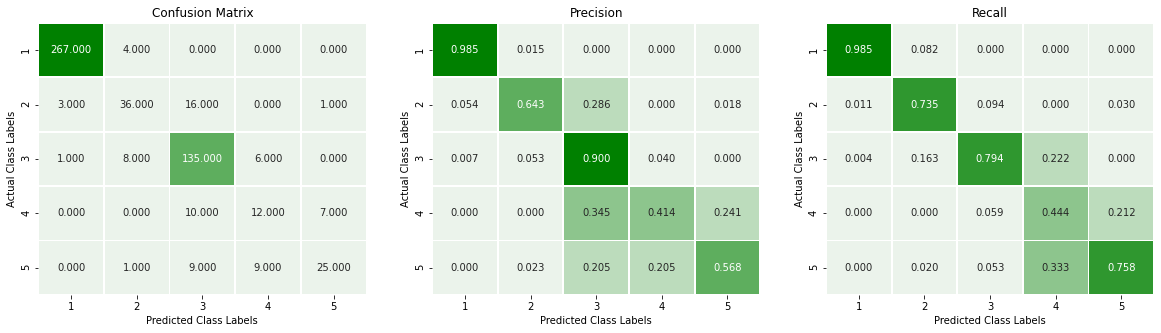

In [ ]:
train_preds = ensembling(train_predictions)
val_preds = ensembling(validation_predictions)
test_preds = ensembling(test_predictions)
metric = PerformanceMetric(validation_predictions['label'], val_preds)
metric.plotting()

In [ ]:
tr_kappa_ = cohen_kappa_score(train_predictions['label'], train_preds,  weights='quadratic' )
val_kappa_ = cohen_kappa_score(validation_predictions['label'], val_preds,  weights='quadratic' )
print("AFter Ensembling of training data we get kappa score of:",tr_kappa_)
print("AFter Ensembling of validation data we get kappa score of:",val_kappa_)

AFter Ensembling of training data we get kappa score of: 0.9560219551062169
AFter Ensembling of validation data we get kappa score of: 0.9314817445952429


In [ ]:
train_predictions['ensemble']=train_preds
validation_predictions['ensemble']=val_preds

In [ ]:
train_predictions.to_csv('/content/drive/My Drive/submission/train.csv',index=False)
validation_predictions.to_csv('/content/drive/My Drive/submission/validation.csv',index=False)
test_predictions.to_csv('/content/drive/My Drive/submission/test.csv',index=False)

# **Overall Results:**

In [ ]:
table = PrettyTable()
table.field_names = ['Sr.No','Model','val_kappa','Trainable Parameters']
table.add_row(['1','Baseline','0.6931','1,86,037'])
table.add_row(['2','AlexNet','0.7758','512,332,165'])
table.add_row(['3','VGG16','0.8931','9,441,797'])
table.add_row(['4','VGG19','0.9128','16,521,221'])
table.add_row(['5','DenseNet','0.923','6,958,981'])
table.add_row(['6','Resnet50','0.9091','23,544,837'])
table.add_row(['7','Resnet152','0.9146','58,229,765'])
table.add_row(['8','Inceptionv3','0.9014','21,778,597'])
table.add_row(['9','EfficientB0','0.9144','4,013,953'])
table.add_row(['10','EfficientB3','0.9199','10,703,917'])
table.add_row(['11','EfficientB4','0.9193','17,557,581'])
table.add_row(['12','Xception','0.9161','20,817,197'])
table.add_row(['13','Ensemble','0.9314','-'])

print(table) 

+-------+-------------+-----------+----------------------+
| Sr.No |    Model    | val_kappa | Trainable Parameters |
+-------+-------------+-----------+----------------------+
|   1   |   Baseline  |   0.6931  |       1,86,037       |
|   2   |   AlexNet   |   0.7758  |     512,332,165      |
|   3   |    VGG16    |   0.8931  |      9,441,797       |
|   4   |    VGG19    |   0.9128  |      16,521,221      |
|   5   |   DenseNet  |   0.923   |      6,958,981       |
|   6   |   Resnet50  |   0.9091  |      23,544,837      |
|   7   |  Resnet152  |   0.9146  |      58,229,765      |
|   8   | Inceptionv3 |   0.9014  |      21,778,597      |
|   9   | EfficientB0 |   0.9144  |      4,013,953       |
|   10  | EfficientB3 |   0.9199  |      10,703,917      |
|   11  | EfficientB4 |   0.9193  |      17,557,581      |
|   12  |   Xception  |   0.9161  |      20,817,197      |
|   13  |   Ensemble  |   0.9314  |          -           |
+-------+-------------+-----------+---------------------